# Gam control experiments

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['240227_1', '240227_2', '240227_3',
                            '230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec',
                            '240227_4', '240301_1', '240301_2'
                            ],
                    groups=['0, Gam', '0, Gam', '0, Gam',
                            '0, WT', '0, WT', '0, WT', '0, WT', '0, WT',
                            '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT', '30 ng/mL, WT',
                            '30 ng/mL, Gam', '30 ng/mL, Gam', '30 ng/mL, Gam'
                            ],
                    metadata='DateTime',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .split_column(col='Group', new_cols=['Cipro', 'Strain'], delimiter=', ')
        )

Dataset 240227_1 (group 0, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240227_2 (group 0, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240227_3 (group 0, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230725_1 (group 0, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group 0, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group 0, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group 0, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group 0, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230118_DT23 (group 30 ng/mL, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230720_1 (group 30 ng/mL, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230720_2 (group 3

In [ ]:
data.describe()

## Cell size

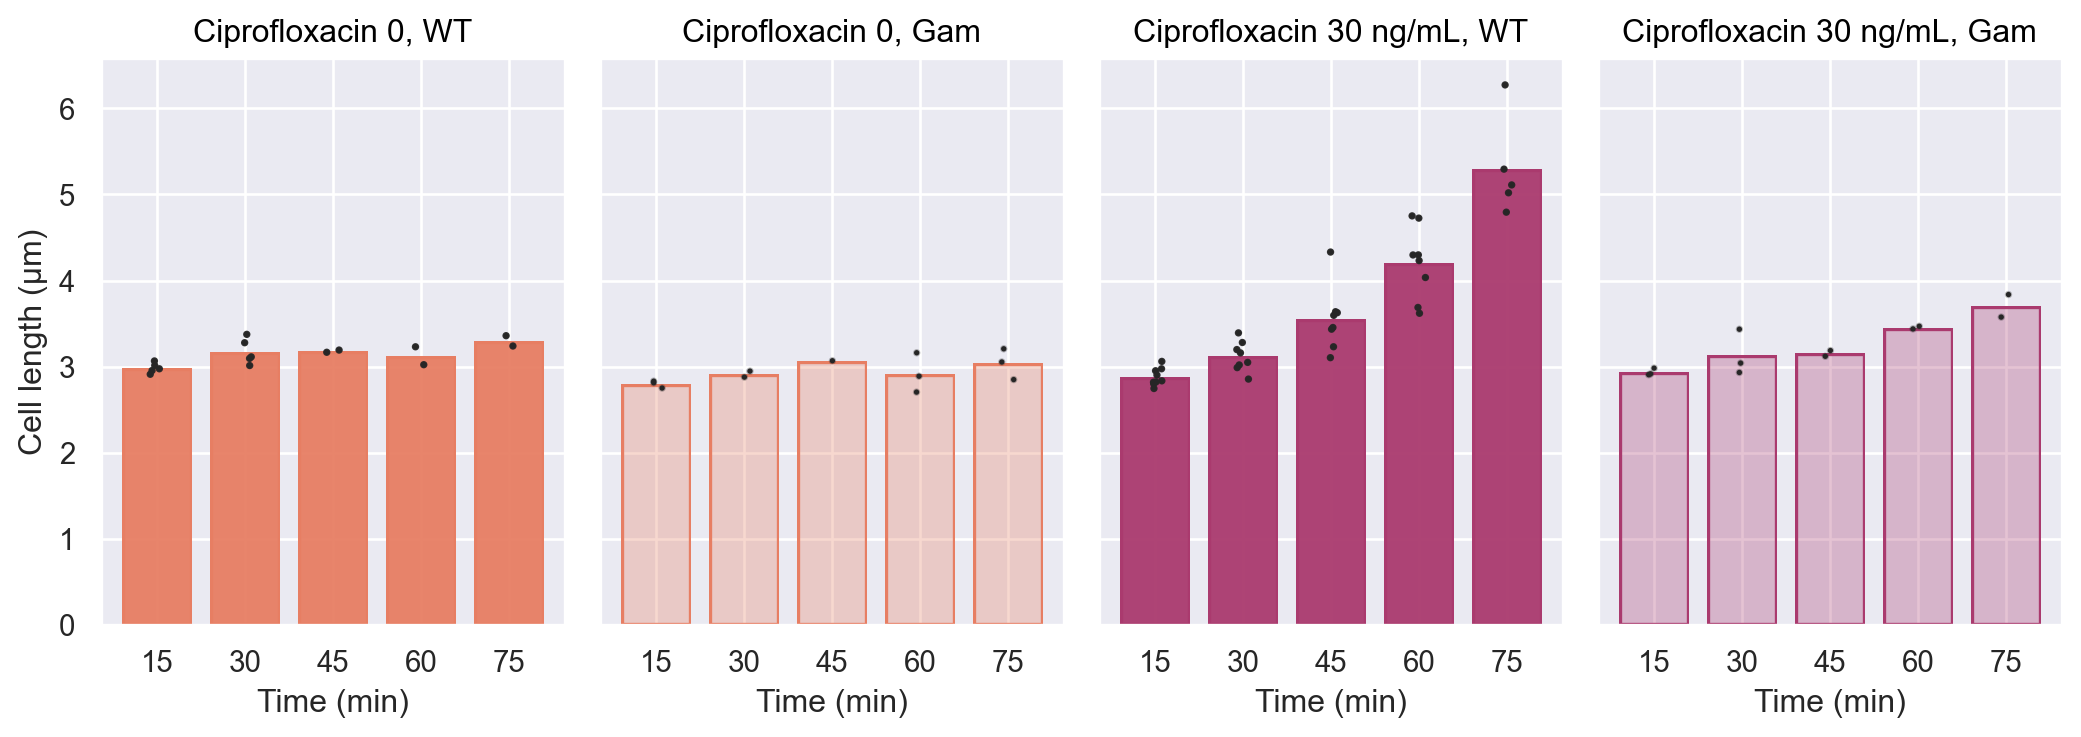

In [3]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .Bacteria_large
      .groupby(['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'])
      .agg({'SpineLength':'mean'})
      .query('Time_min_bin < 90')
      )

(
 so.Plot(df, x='Time_min_bin', y='SpineLength', color='Cipro', alpha='Strain')
 .layout(size=(11, 4))
 .facet(col='Group', order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
 .add(so.Bar(), so.Agg(), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', '', '', '30 ng/mL']), alpha=so.Nominal(order=['WT', 'Gam']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Cell length (µm)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin', alpha='Strain')
#  .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Cell_length_Gam.pdf', format='pdf', bbox_inches='tight')
 )

## Number of spots per cell area

,norm_count
Group,
"0, Gam",0.699299
"0, WT",0.418825
"30 ng/mL, Gam",0.610367
"30 ng/mL, WT",0.839870


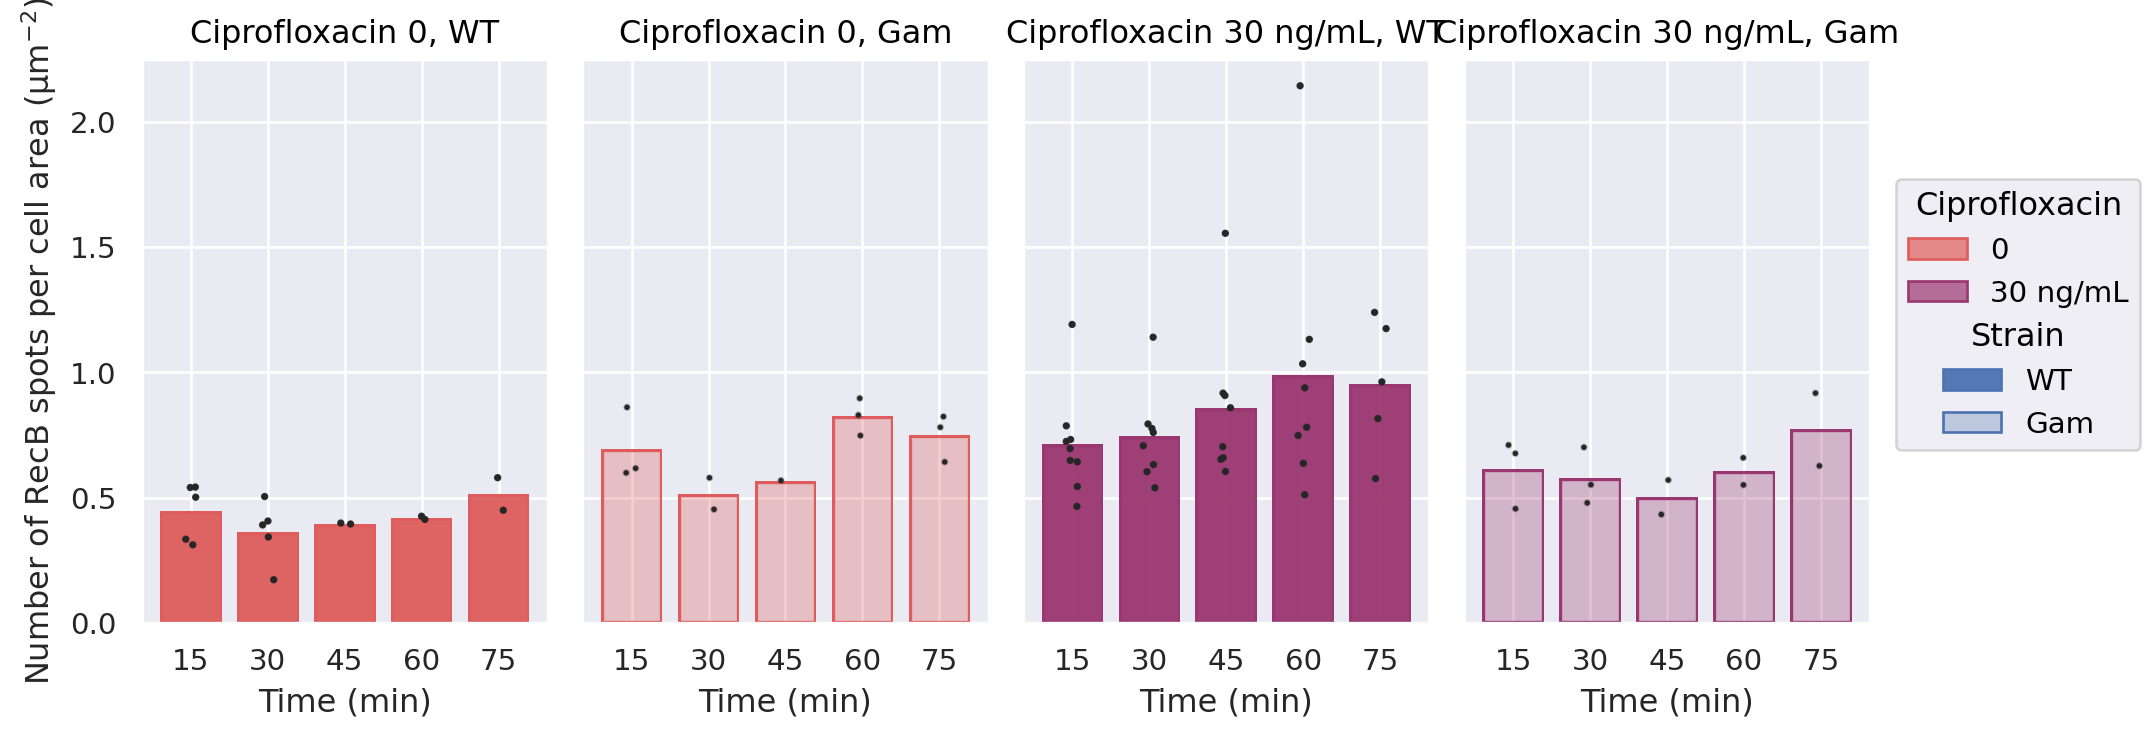

In [13]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin', 'ParentIndices']) # Group per cell
      .agg({'Indices': 'count', 'Area': 'mean'}) # Count number of spots (trackheads only, so we're not biased by track length) per cell
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area) # Normalise spot count by cell area
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'])
      .agg({'norm_count': 'sum'}) # Sum all spots for each bin (can't do a mean, otherwise it would exclude cells with 0 spots)
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None)) # Add the number of cells for each bin (including those that have 0 spots)
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells
              )  # Divide the total count by the number of cells in the bin
      .query('Time_min_bin < 90')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Cipro', alpha='Strain')
 .layout(size=(10, 4))
 .facet(col='Group', order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
 .add(so.Bar(), so.Agg())
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', '30 ng/mL']), x=so.Continuous().tick(every=15), alpha=so.Nominal(order=['WT', 'Gam']))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
#  .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Gam_num_spots.svg', format='svg', bbox_inches='tight')
 )

### Gam: number of spots per cell

In [25]:
df = (data
      .Bacteria_large
      .query('Strain == "Gam"')
      .groupby(['Dataset', 'Position', 'Idx'])
      .agg({'RecBSpotCount':'sum'})
      .groupby('Dataset')
      .agg({'RecBSpotCount':['mean','sem']})
      .mean()
      )

display(df)

RecBSpotCount  mean    4.112115
               sem     0.208518
dtype: float64

### Remove the timeseries dimension

,norm_count
Group,
"0, Gam",0.678296
"0, WT",0.404152
"30 ng/mL, Gam",0.616245
"30 ng/mL, WT",0.759140


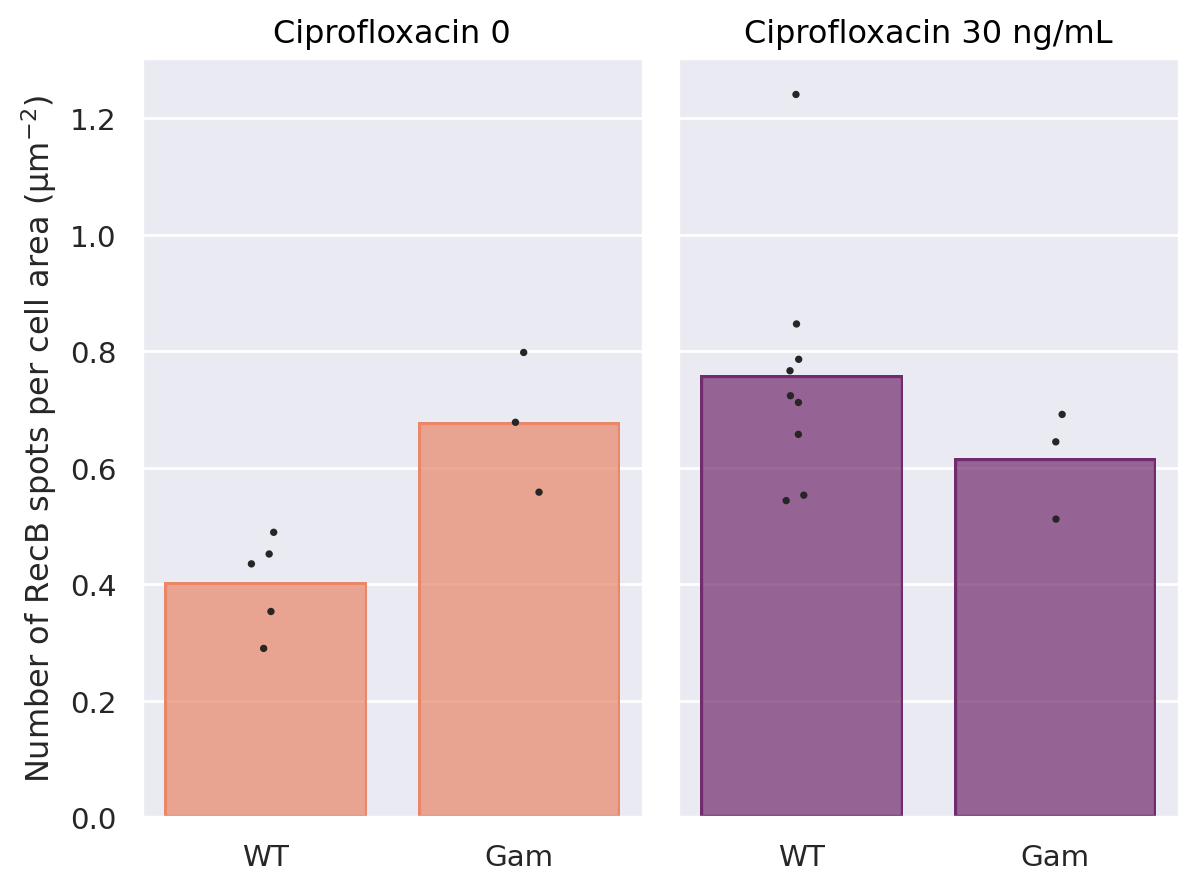

In [16]:
import seaborn.objects as so

df = (data
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset', 'ParentIndices']) # Group per cell
      .agg({'Indices': 'count', 'Area': 'mean'}) # Count number of spots (trackheads only, so we're not biased by track length) per cell
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area) # Normalise spot count by cell area
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset'])
      .agg({'norm_count': 'sum'}) # Sum all spots for each bin (can't do a mean, otherwise it would exclude cells with 0 spots)
      .reset_index()
      .merge(data.Bacteria_large.groupby('Dataset')['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on='Dataset',
             suffixes=('_old', None)) # Add the number of cells for each bin (including those that have 0 spots)
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells # Divide the total count by the number of cells in the bin
              )
      )

(
 so.Plot(df, x='Strain', y='norm_count', color='Cipro')
 .facet(col='Cipro')
 .add(so.Bar(), so.Agg(), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', 'a', 'b', 'c', '30 ng/mL']),  x=so.Nominal(order=['WT', 'Gam']))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x='', y="Number of RecB spots per cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='')
#  .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Gam_num_spots.svg', format='svg', bbox_inches='tight')
 )

### Filter for TrackLength > 10 sec (=5 frames)

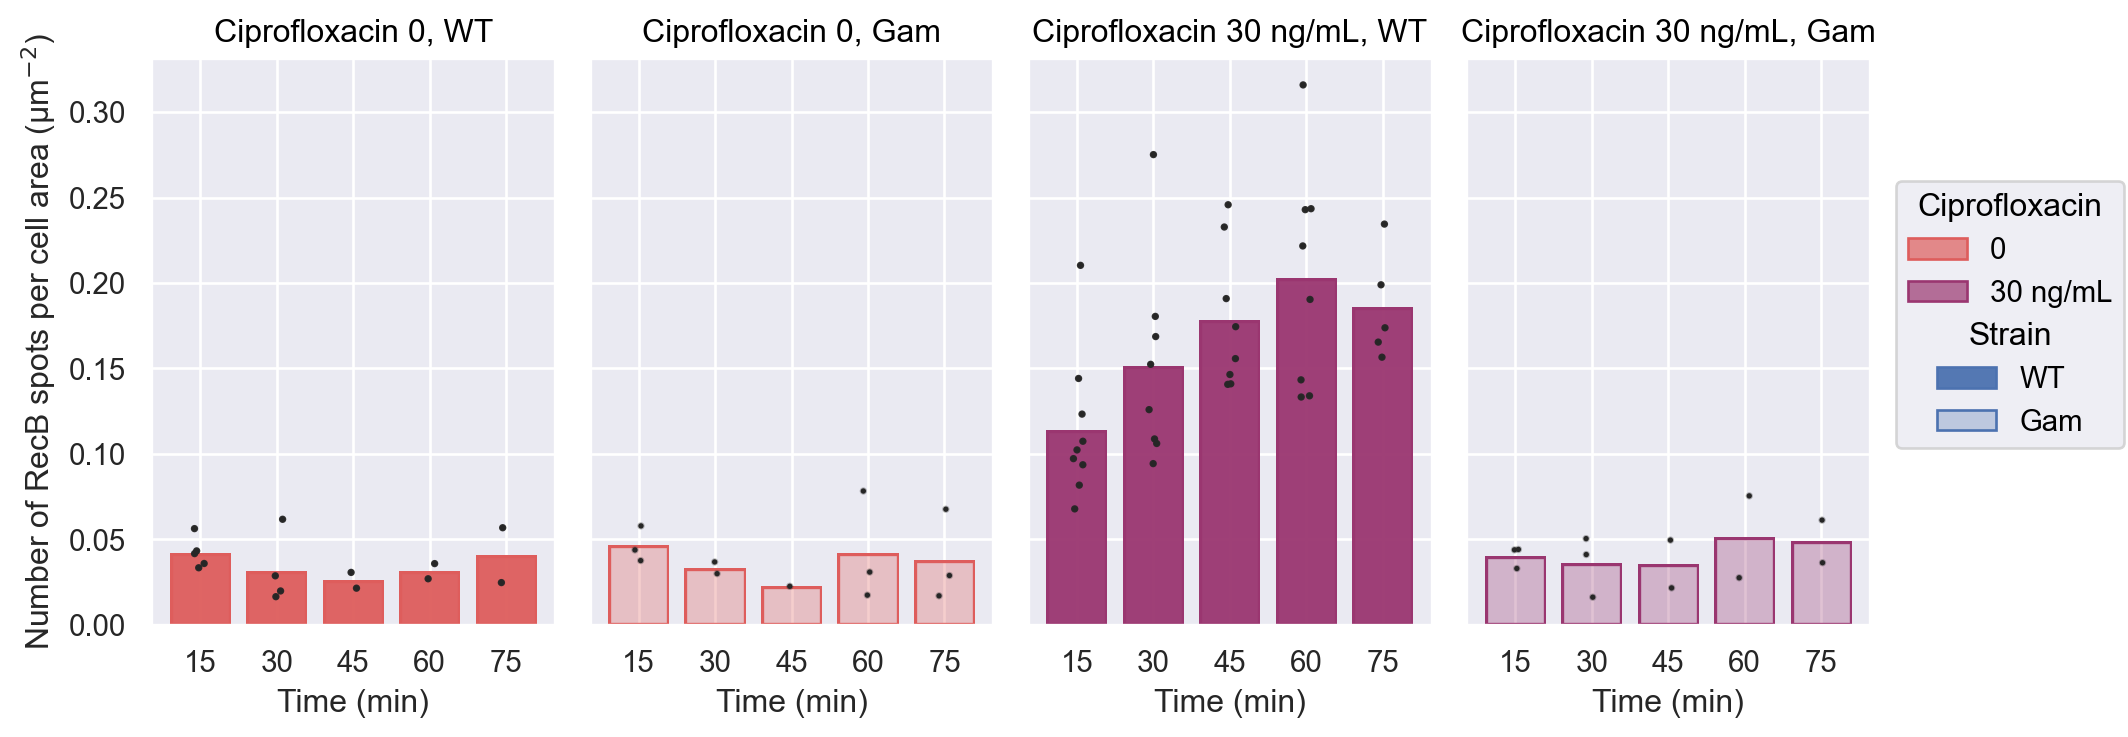

In [4]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots', long_spot=lambda df: df.TrackLength.ge(5).astype('int'))
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin', 'ParentIndices', 'long_spot']) # Group per cell
      .agg({'Indices': 'count', 'Area': 'mean'}) # Count number of spots (trackheads only, so we're not biased by track length) per cell
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area) # Normalise spot count by cell area
      .groupby(by=['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin', 'long_spot'])
      .agg({'norm_count': 'sum'}) # Sum all spots for each bin (can't do a mean, otherwise it would exclude cells with 0 spots)
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None)) # Add the number of cells for each bin (including those that have 0 spots)
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells
              )  # Divide the total count by the number of cells in the bin
      .query('Time_min_bin < 90 and long_spot == 1')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Cipro', alpha='Strain')
 .layout(size=(10, 4))
 .facet(col='Group', order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
 .add(so.Bar(), so.Agg())
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', '30 ng/mL']), x=so.Continuous().tick(every=15), alpha=so.Nominal(order=['WT', 'Gam']))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
#  .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

## RecB spots intensity

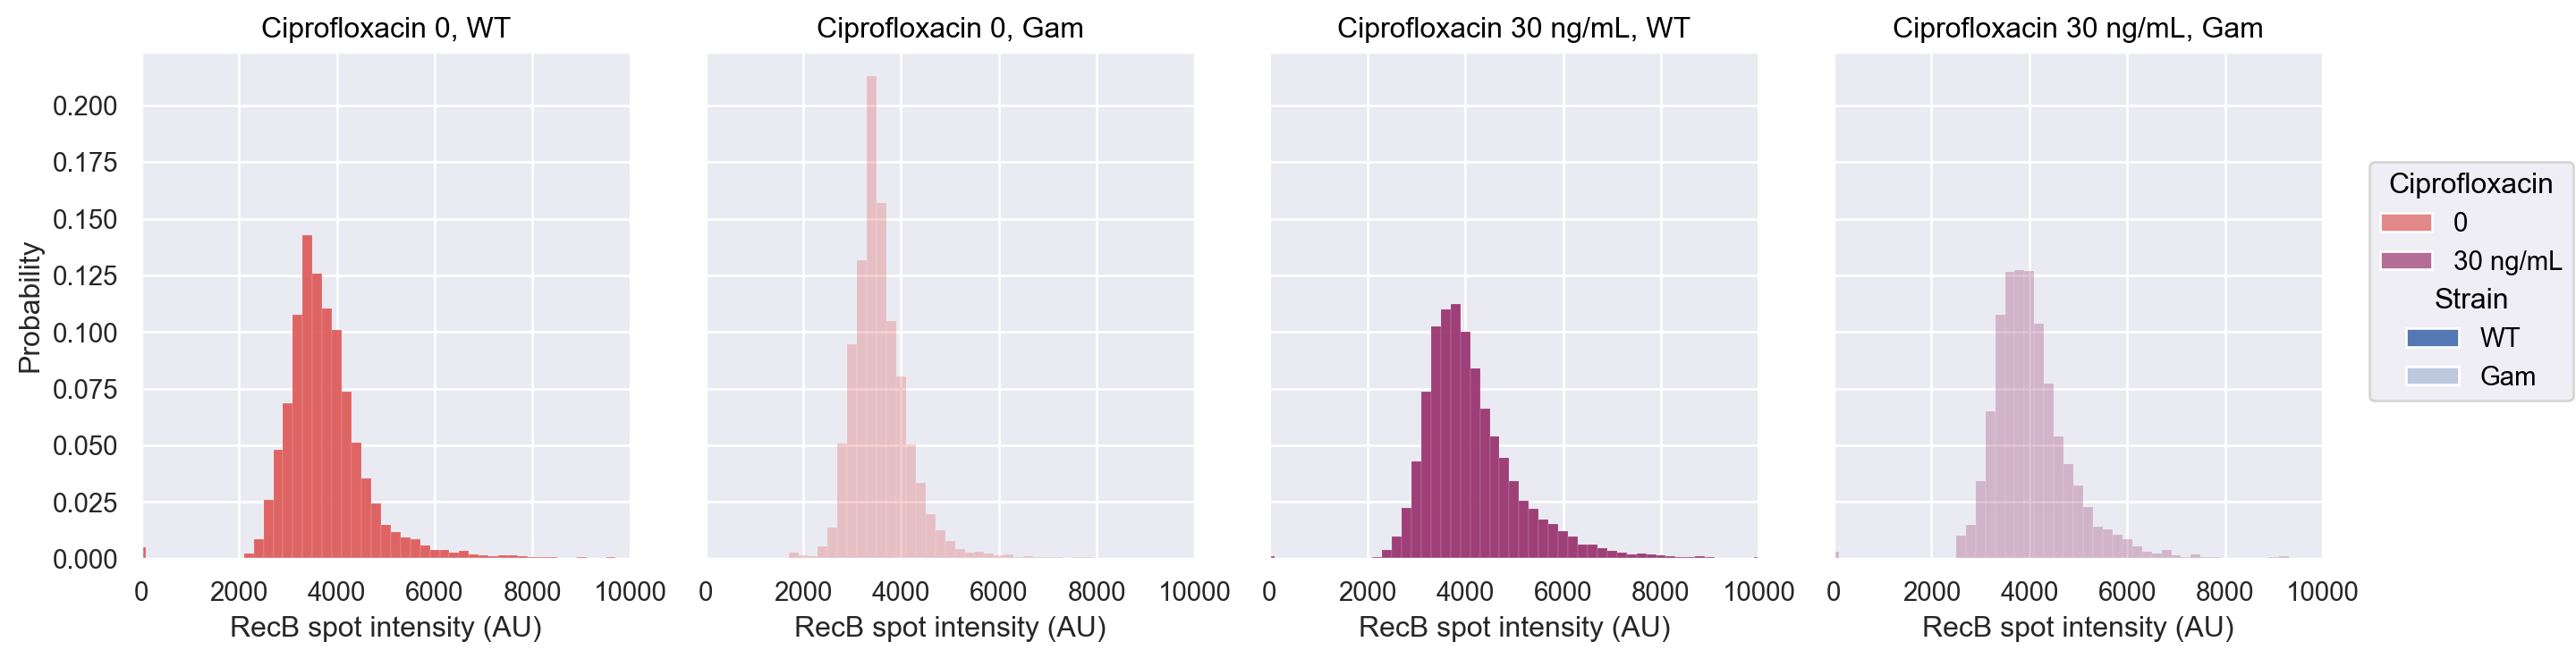

In [80]:
from pyberries.data import get_histogram

hist = get_histogram(data.RecB_spots, col='Raw_intensity', groupby=['Dataset','Group', 'Cipro', 'Strain'], density=True, binsize=200, binlabels='left')

(
    so.Plot(hist, x='Raw_intensity', y='proportion', color='Cipro', alpha='Strain')
    .layout(size=(14, 4))
    .facet(col='Group',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
    .add(so.Bars(), so.Agg())
    .scale(x=so.Continuous(), color=so.Nominal('flare', order=['0', '30 ng/mL']), alpha=so.Nominal(order=['WT', 'Gam']))
    .limit(x=(0, 10000), y=(None, None))
    .label(x="RecB spot intensity (AU)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
)

## RecB lifetime histogram fit

### Mono-exponential fit

In [2]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group', 'Cipro', 'Strain'], density=True, binlabels='left')
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Dataset','Group', 'Cipro', 'Strain'], p0=[1, 0.1])

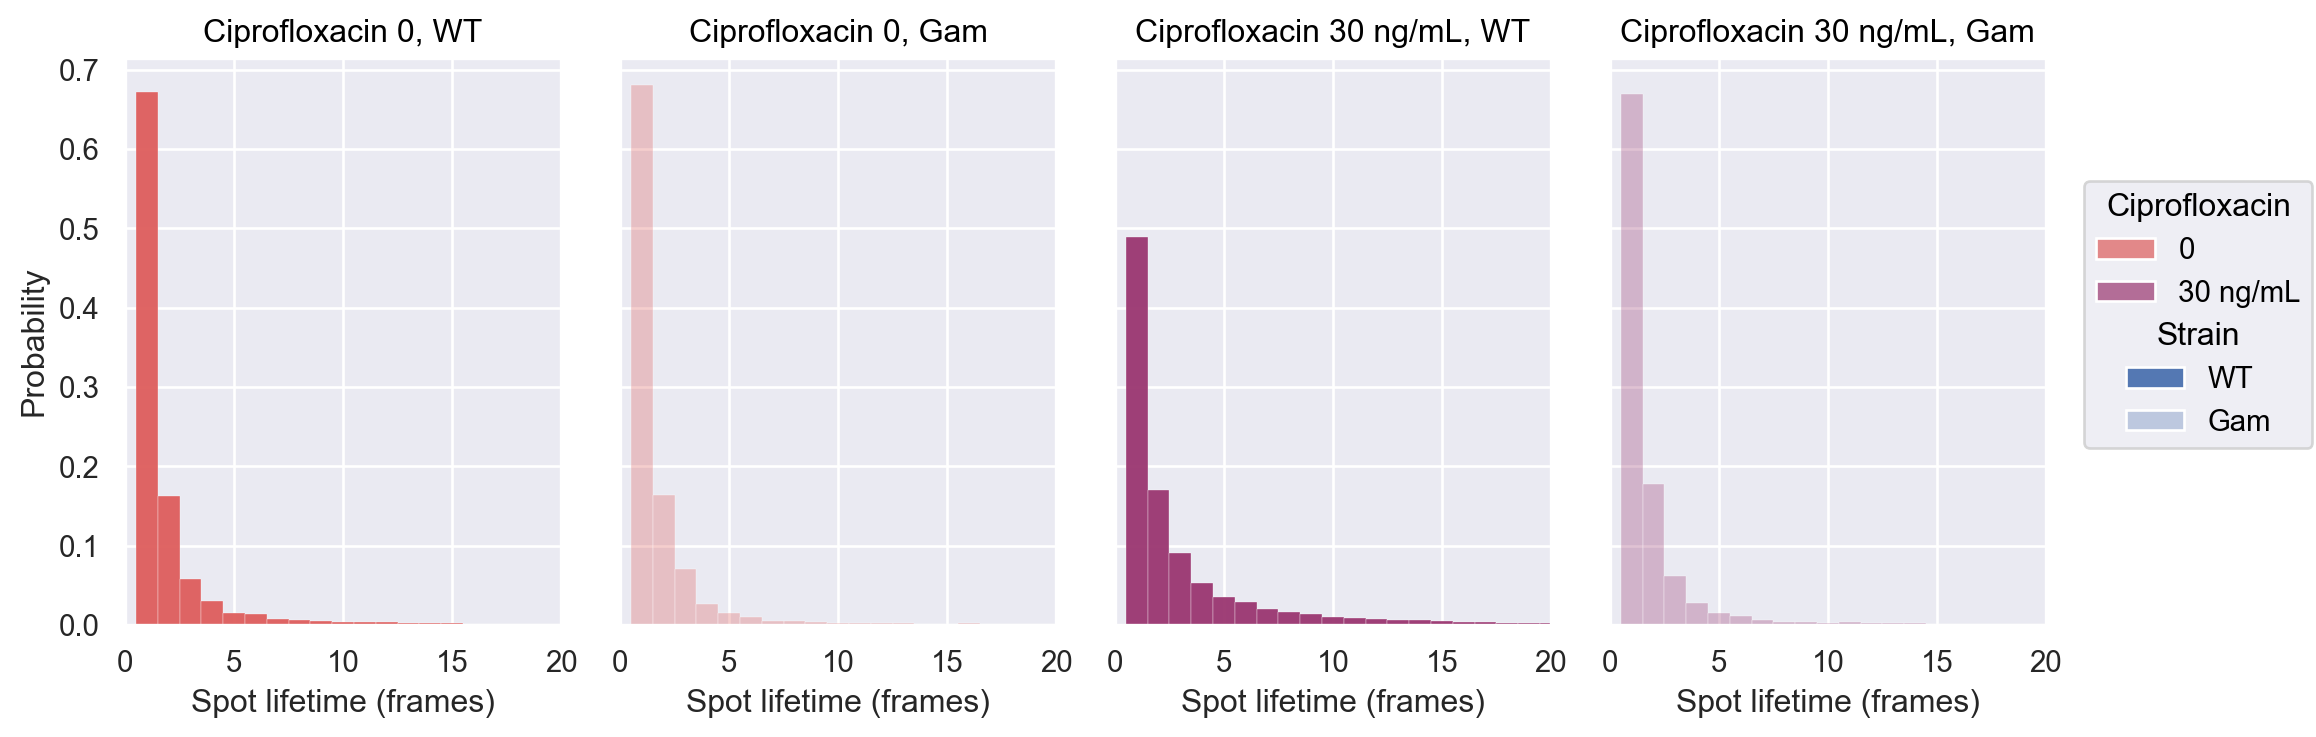

In [90]:
import seaborn.objects as so

(
    so.Plot(hist, x='TrackLength', y='proportion', color='Cipro', alpha='Strain')
    .layout(size=(11, 4))
    .facet(col='Group',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
    .add(so.Bars(), so.Agg())
    .scale(x=so.Continuous(), color=so.Nominal('flare',  order=['0', '30 ng/mL']), alpha=so.Nominal(order=['WT', 'Gam']))
    .limit(x=(0, 20), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
)

Define a threshold so that 95% of RecB spots in Gam experiments are shorter

TrackLength_s    10.0
dtype: float64

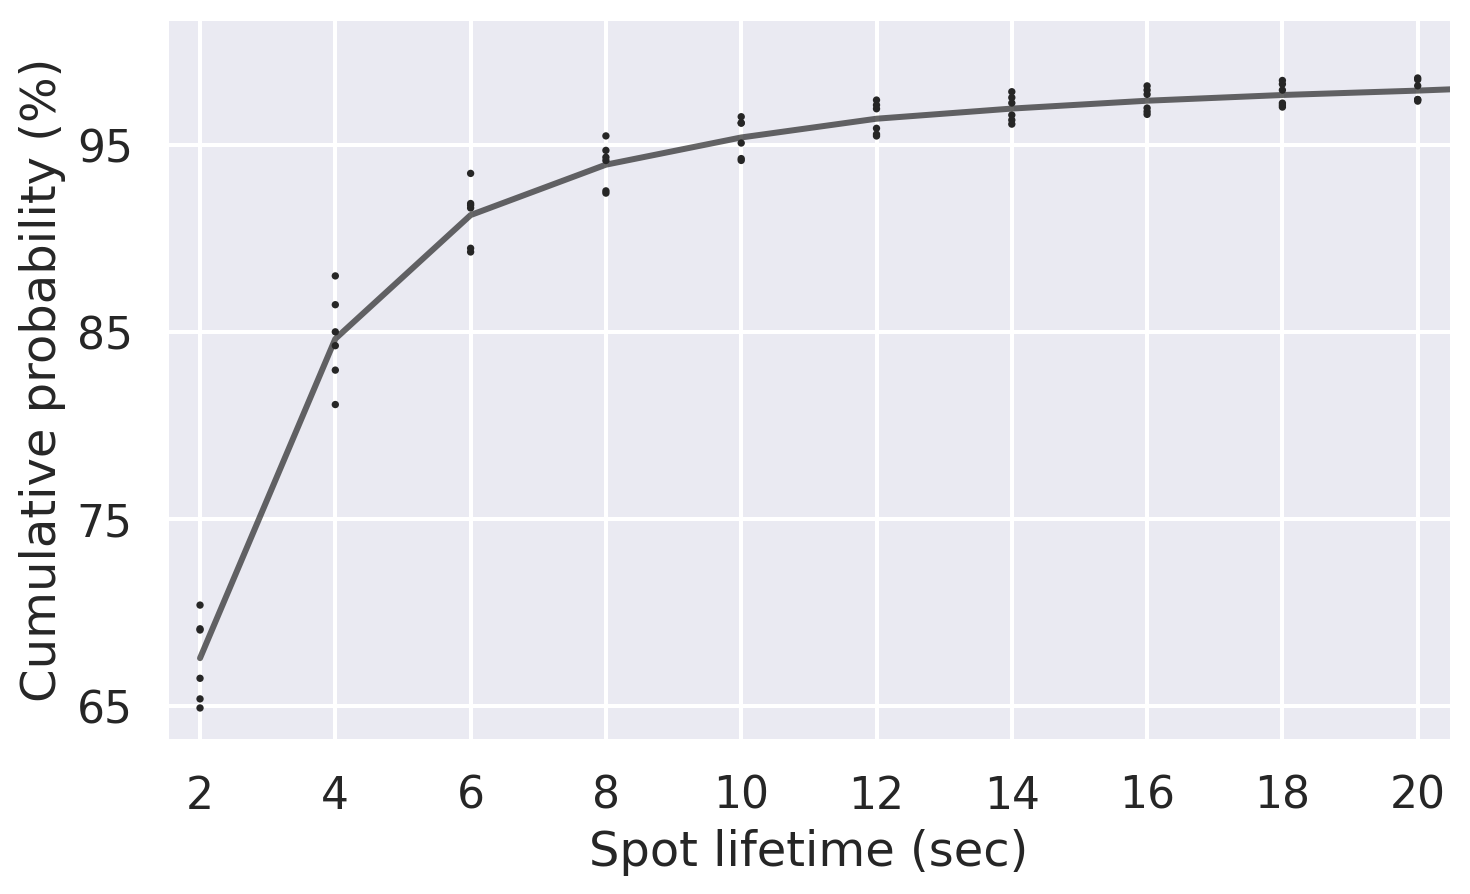

In [65]:
import pandas as pd
import seaborn.objects as so
from seaborn import plotting_context
import numpy as np

df = (hist
      .query('Strain == "Gam"')
      .sort_values('TrackLength')
      .assign(Sum_shorter=lambda df: df.groupby('Dataset')['proportion'].cumsum().mul(100),
              TrackLength_s=lambda df: df.TrackLength*2
              )
      )

display(df.query('Sum_shorter > 95').groupby('Dataset').agg({'TrackLength_s':'min'}).median())

(
    so.Plot(df, x='TrackLength_s', y='Sum_shorter')
    .layout(size=(8, 5))
    .add(so.Line(color='k', alpha=0.7), so.Agg())
    .add(so.Dots(color='k', marker='.', fillalpha=1))
    .scale(x=so.Continuous().tick(every=2), y=so.Continuous().tick(at=[65, 75, 85, 95]))
    .limit(x=(1.5, 20.5))
    .label(x='Spot lifetime (sec)', y='Cumulative probability (%)')
    .theme(plotting_context("talk"))
    # .save('/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Gam_thresholding.svg', format='svg', bbox_inches='tight')
)

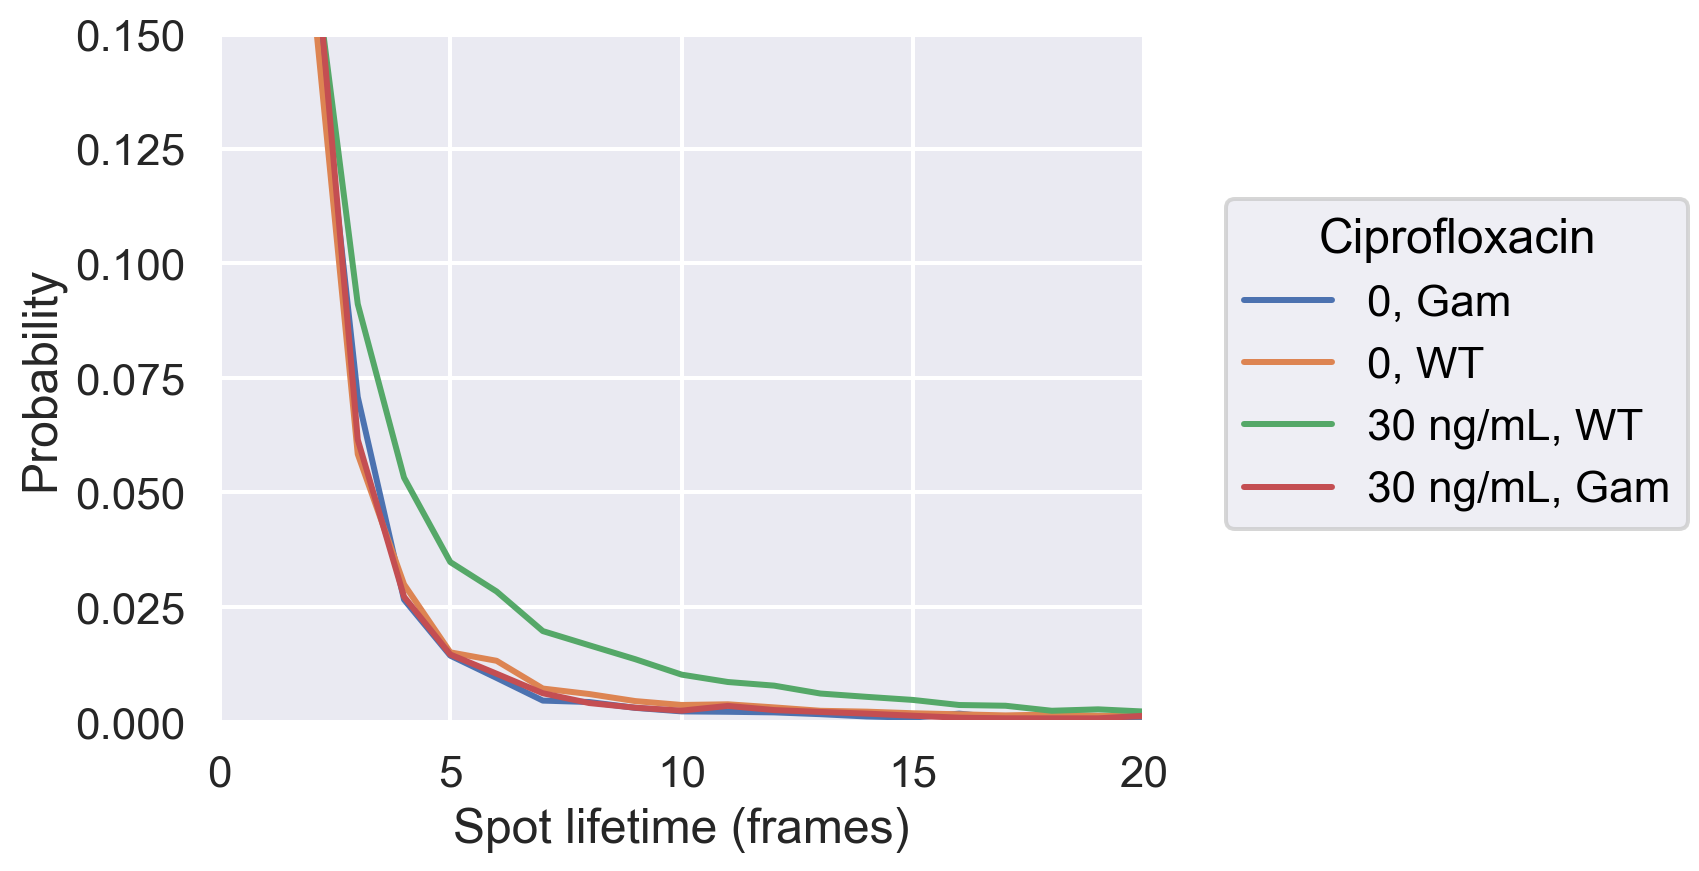

In [95]:
import seaborn.objects as so
from seaborn import plotting_context

(
    so.Plot(hist, x='TrackLength', y='proportion', color='Group')
    .add(so.Line(), so.Agg())
    .scale(x=so.Continuous(), color=so.Nominal('deep'))
    .limit(x=(0, 20), y=(0, 0.15))
    .label(x="Spot lifetime (frames)", y="Probability", color='Ciprofloxacin', title='')
    .theme(plotting_context("talk"))
)

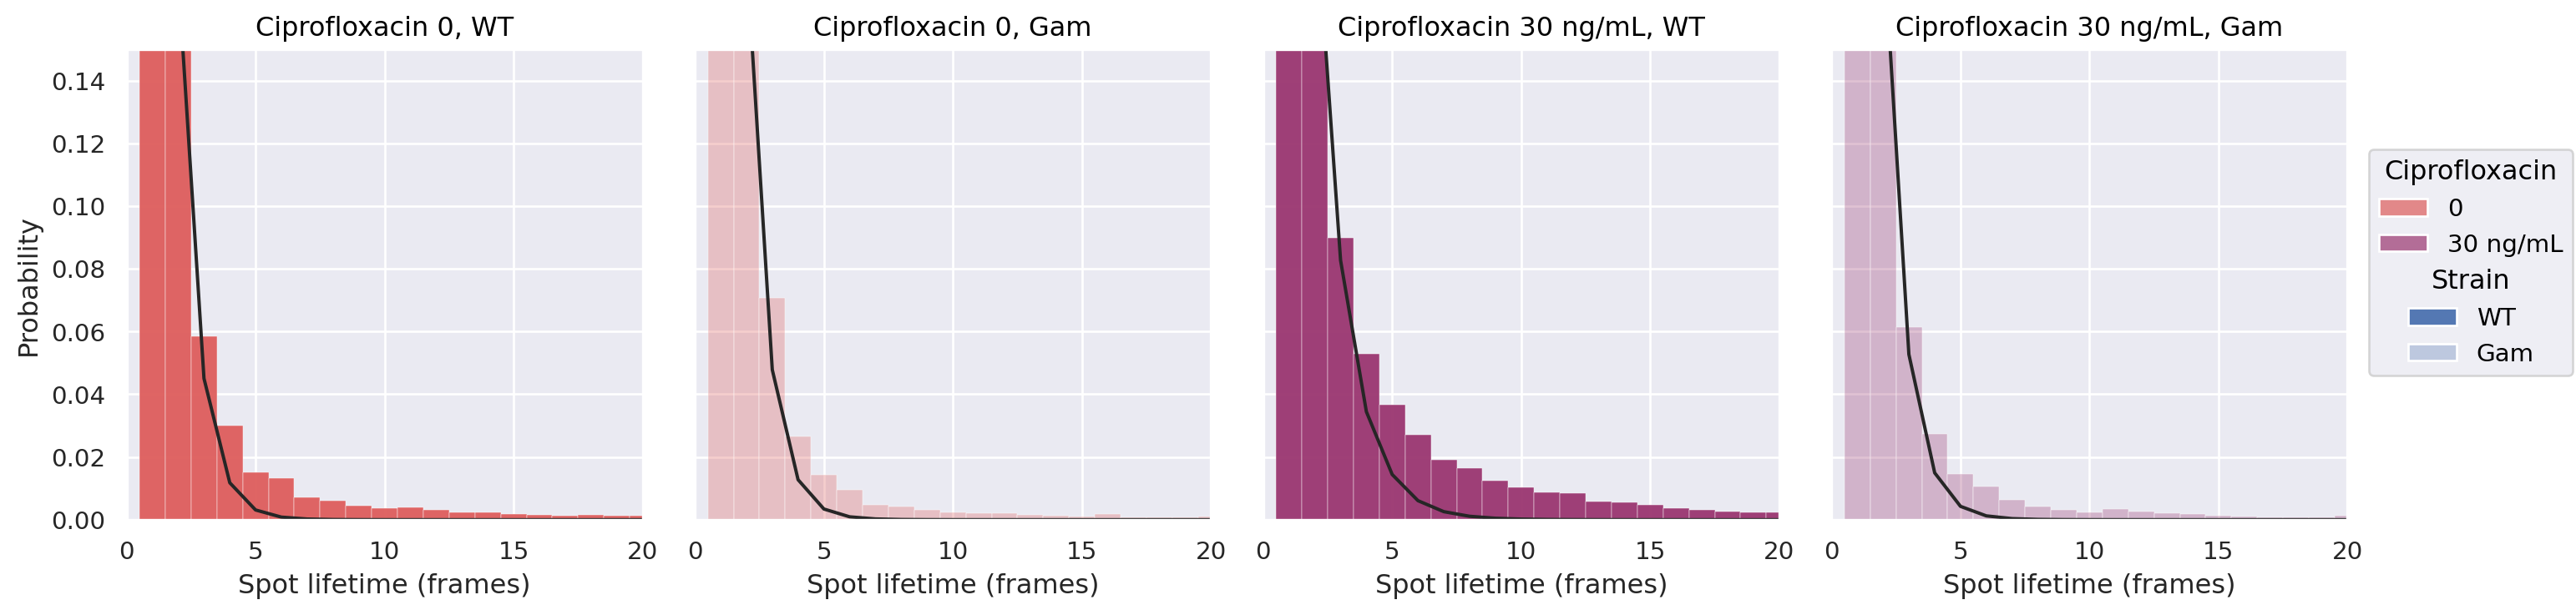

In [3]:
import seaborn.objects as so

(
    so.Plot(monoexp_fit.data, x='TrackLength', color='Cipro', alpha='Strain')
    .layout(size=(15, 4))
    .facet(col='Group',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
    .add(so.Bars(), so.Agg(), y='proportion')
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare',  order=['0', '30 ng/mL']), alpha=so.Nominal(order=['WT', 'Gam']))
    .limit(x=(0, 20), y=(None, 0.15))
    .label(x="Spot lifetime (frames)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
)

Cipro 30 ng/mL only

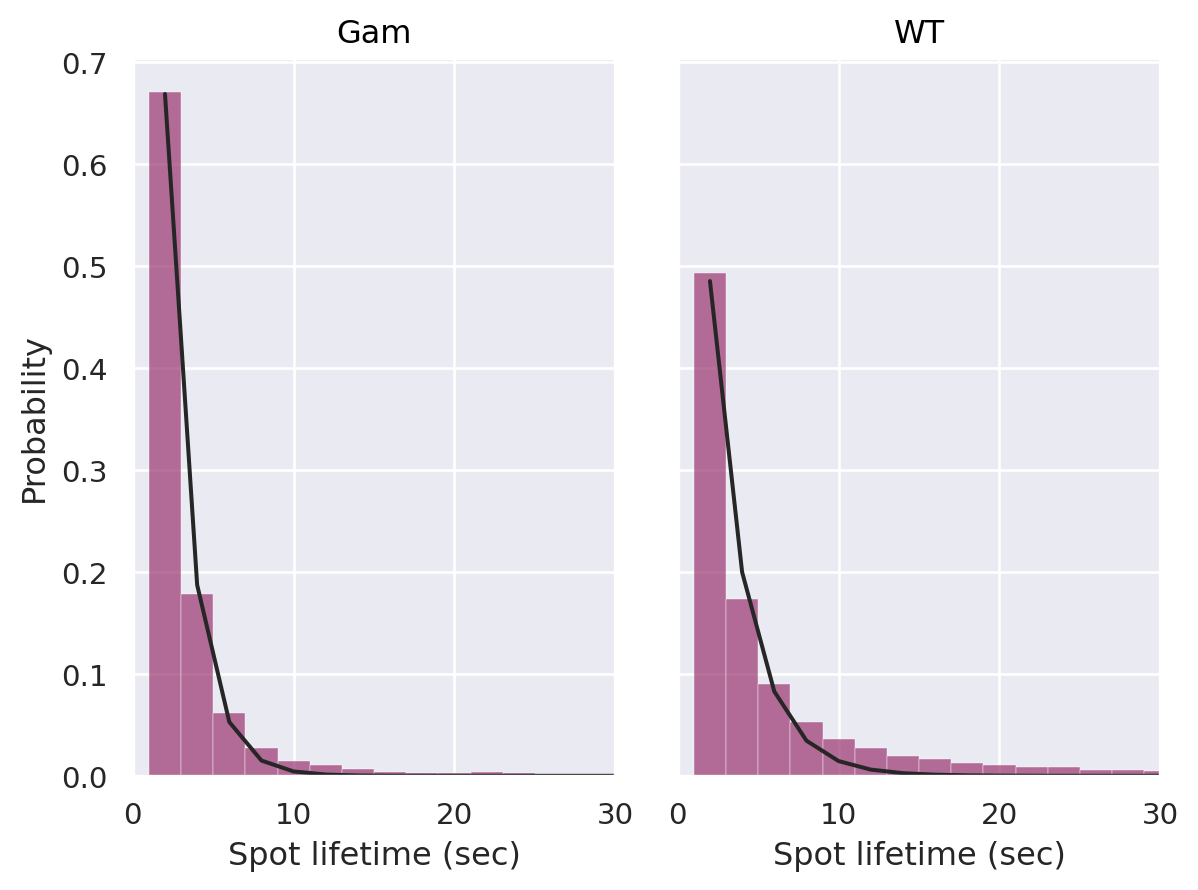

In [39]:
import seaborn.objects as so

df = (monoexp_fit.data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      .query("Cipro == '30 ng/mL'")
      )

(
    so.Plot(df, x='TrackLength_s', color='Cipro')
    .facet(col='Strain',  order=['Gam', 'WT'])
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .scale(color=so.Nominal('flare',  order=['0', '30 ng/mL']))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article_figures/SI_Figures/Monoexp_fits_Gam_cipro30.pdf', format='pdf', bbox_inches='tight')
)

,Fitted_param
Group,
"0, Gam",1.327667
"0, WT",1.355684
"30 ng/mL, Gam",1.274271
"30 ng/mL, WT",0.887092


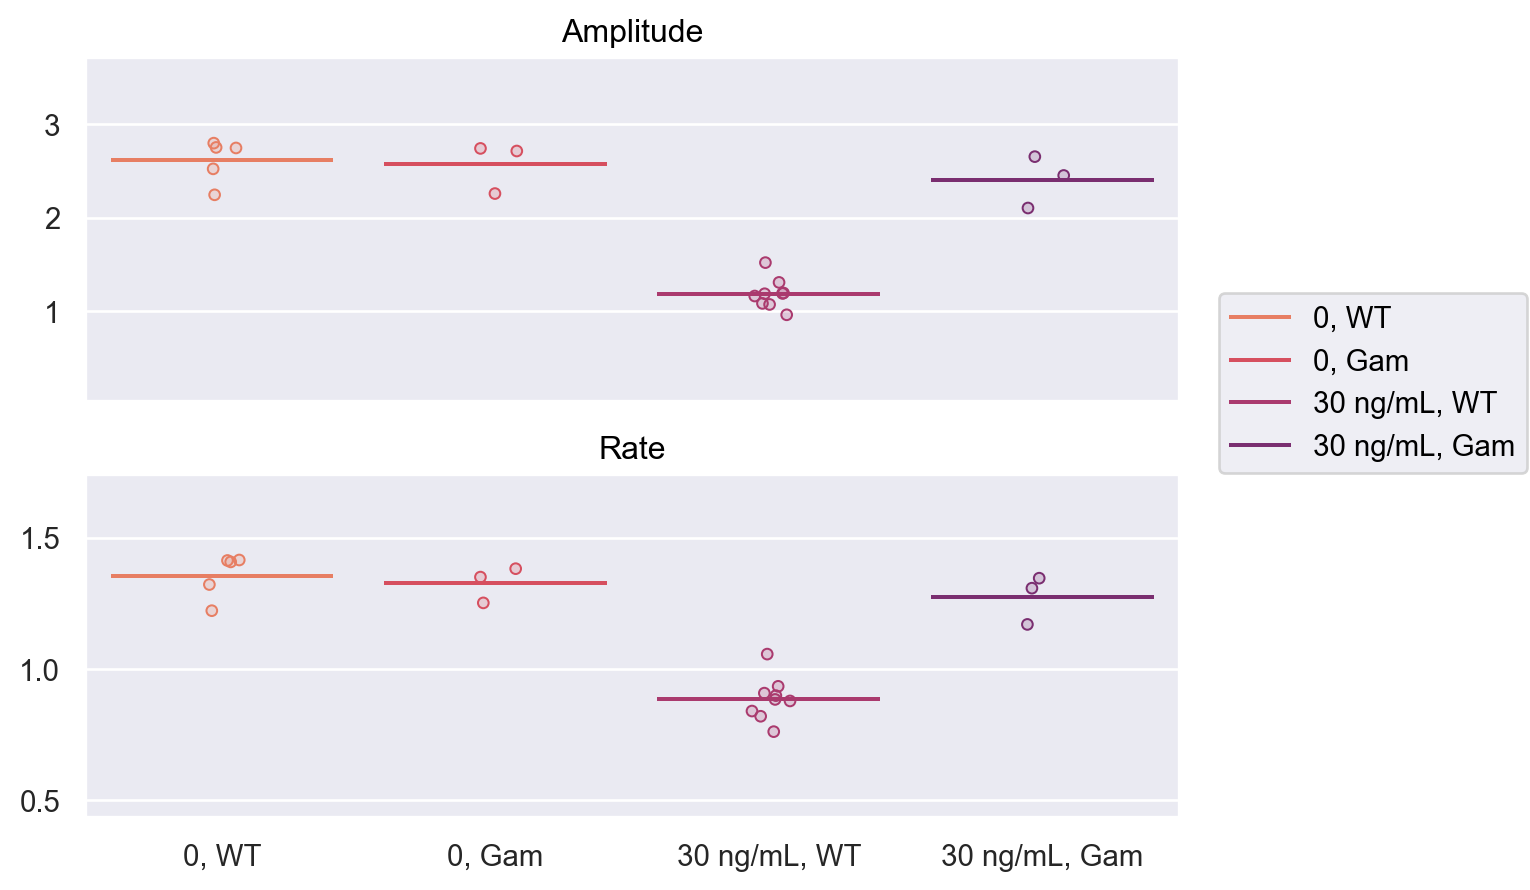

In [9]:
import seaborn.objects as so

monoexp_parameters = monoexp_fit.get_fit_parameters(param_names=['Amplitude', 'Rate'])

display(monoexp_parameters.query('Param_name == "Rate"').groupby('Group').agg({'Fitted_param':'mean'}))

(
    so.Plot(monoexp_parameters, x='Group', y='Fitted_param', color='Group')
    .facet(row='Param_name')
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam']), x=so.Nominal('flare',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam']))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

### Bi-exponential fit

In [2]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group','Cipro','Strain'], density=True, binlabels='left')
biexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset','Group','Cipro','Strain'], p0=[1, 1, 0.1, 0.1])

Fit for dataset ('240227_1', '0, Gam', '0', 'Gam') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit for dataset ('240227_3', '0, Gam', '0', 'Gam') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


#### Show fit components

In [3]:
from pyberries.data import get_model
import pandas as pd

monoexp_decay = get_model('monoexp_decay')

biexp_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in biexp_fit.data.groupby('Dataset'):
    params = biexp_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    biexp_fit.data.loc[biexp_fit.data.Dataset == ds,:] = df

In [4]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes = (biexp_fit
             .parameters
             .copy()
             .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
             .replace({'1':'Short', '2':'Long'})
             .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Dataset'], columns=['Parameter', 'Rate_type']))
             .reset_index()
             .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short) *2,
                     Lifetime_Long=lambda df: 1/(df.Value.Rate.Long) *2,
                     Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                     Population_Short=lambda df: 100 - df.Population_Long
                     )
             .drop(columns=['Value'], level=0)
             .droplevel(['Parameter', 'Rate_type'], axis=1)
             .melt(id_vars=['Group', 'Dataset'])
             .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
             .drop(columns='variable')
             )

In [5]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Group', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(2)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_mean', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_mean', 'Population_std'], new='Proportion (\%)', delimiter=' $\pm$ '))
      [['Lifetime (sec)', 'Proportion (\%)']]
      .rename_axis(['Ciprofloxacin', 'Population'])
      .reindex(['Short', 'Long'], level=1)
      )

display(df)

Lifetime (sec)   Proportion (\%)
Ciprofloxacin Population                                   
0, Gam        Short        1.34 $\pm$ nan   98.29 $\pm$ nan
              Long         6.31 $\pm$ nan    1.71 $\pm$ nan
0, WT         Short        1.21 $\pm$ 0.2  97.35 $\pm$ 0.95
              Long        6.28 $\pm$ 1.12   2.65 $\pm$ 0.95
30 ng/mL, Gam Short       1.34 $\pm$ 0.21  97.07 $\pm$ 2.06
              Long        6.26 $\pm$ 1.61   2.93 $\pm$ 2.06
30 ng/mL, WT  Short       1.45 $\pm$ 0.21  92.19 $\pm$ 2.12
              Long        8.18 $\pm$ 1.27   7.81 $\pm$ 2.12

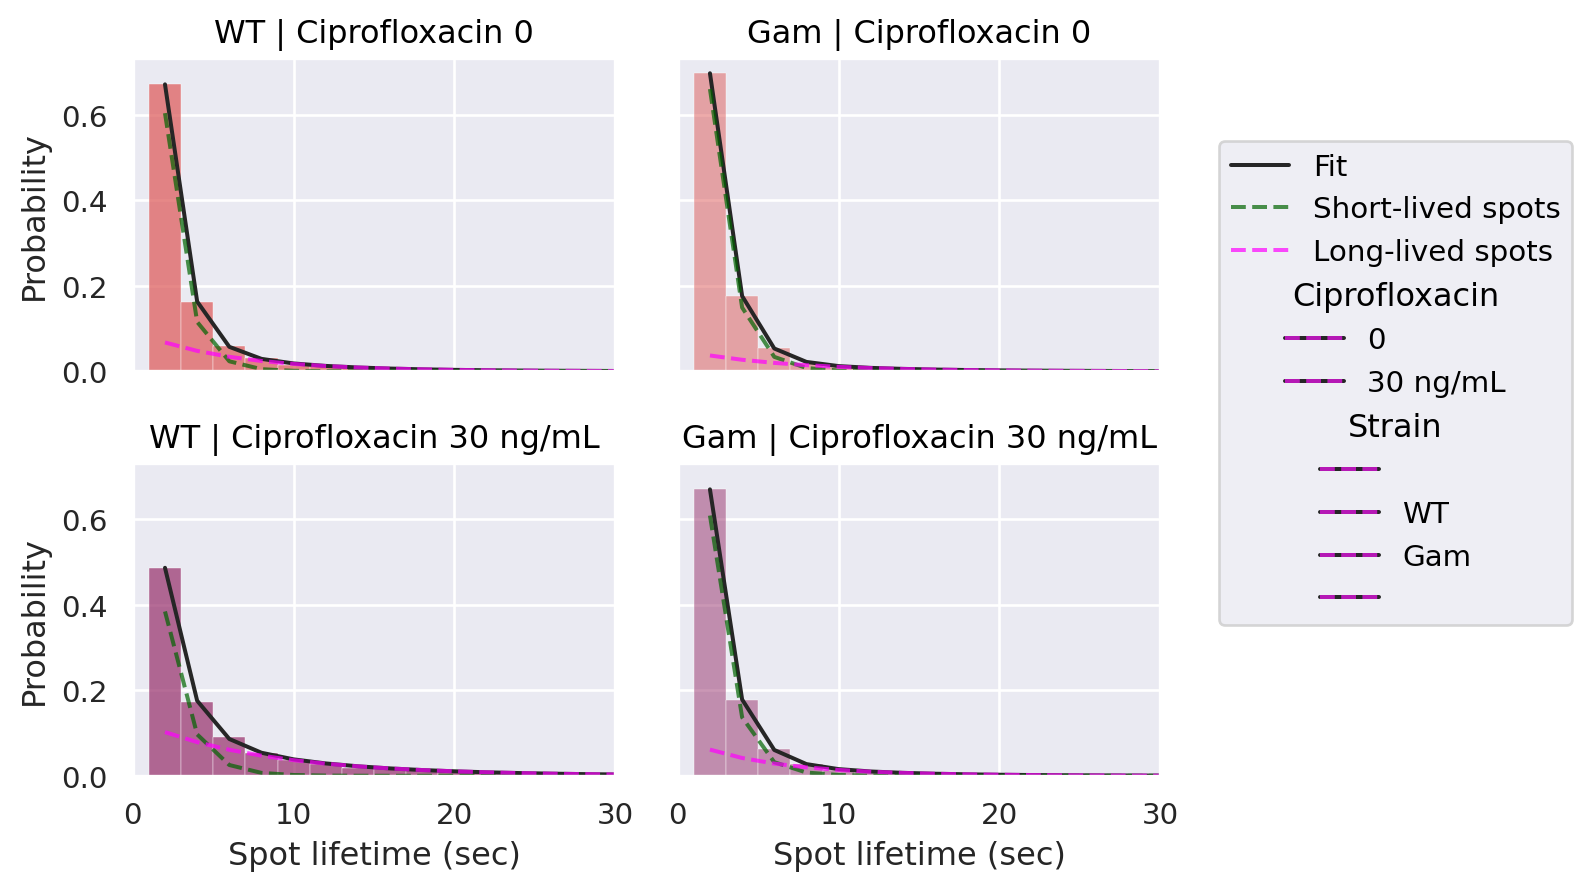

In [6]:
import seaborn.objects as so

df = (biexp_fit
      .data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      )

(
    so.Plot(df, x='TrackLength_s', color='Cipro', alpha='Strain')
    # .layout(size=(12,4))
    # .facet(col='Group', order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam'])
    .facet(col='Strain', row='Cipro', order={'col':['WT', 'Gam']})
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', label='Fit')
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', label='Short-lived spots')
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', label='Long-lived spots')
    .scale(color='flare', alpha=so.Nominal(order=['', 'WT', 'Gam', '']))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', row='Ciprofloxacin')
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

#### Showing only Gam data

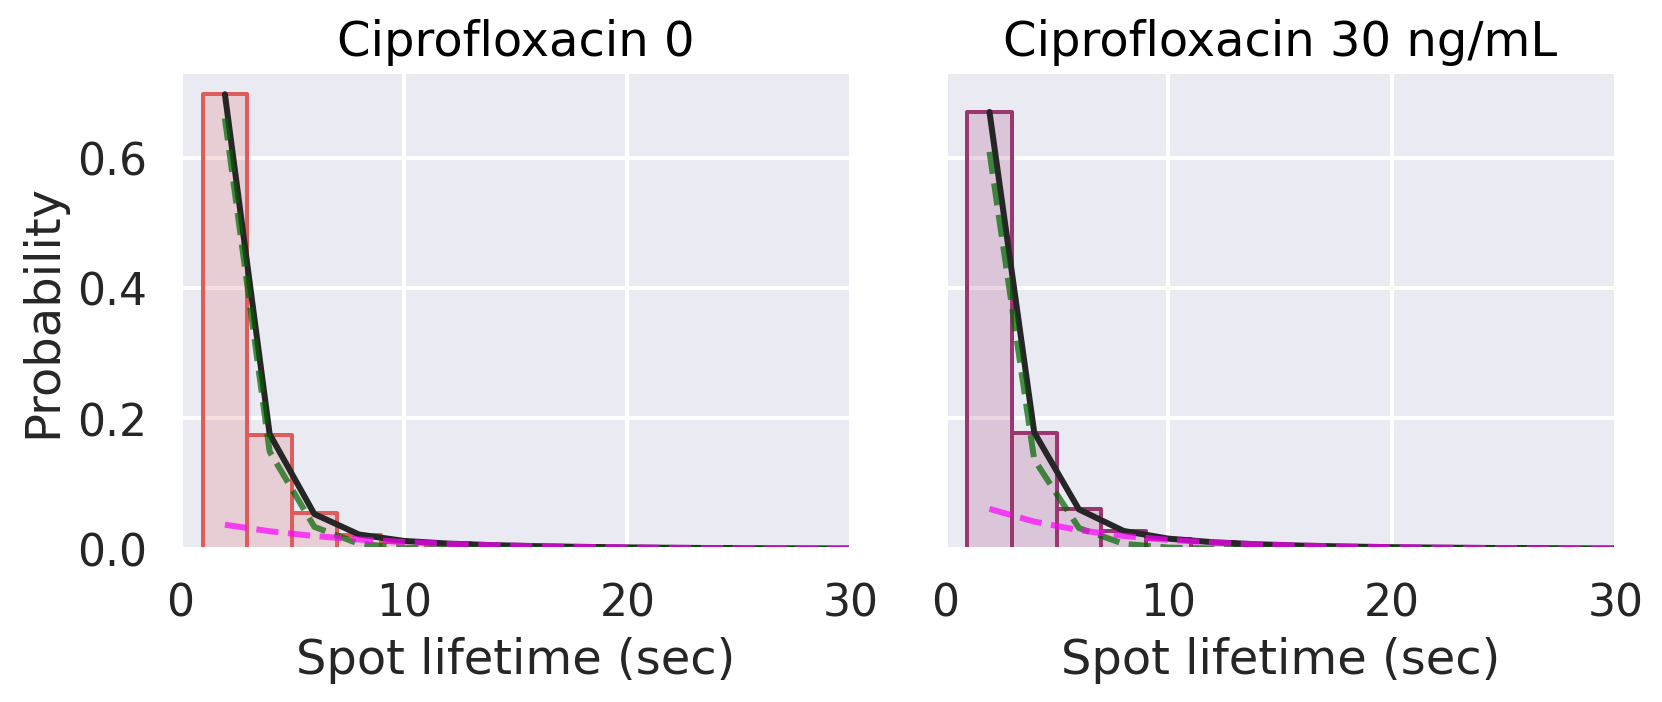

In [10]:
import seaborn.objects as so
from seaborn import plotting_context

df = (biexp_fit
      .data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      .query("Strain == 'Gam'")
      )

(
    so.Plot(df, x='TrackLength_s', edgecolor='Cipro', color='Cipro')
    .layout(size=(9,4))
    .facet(col='Cipro')
    .add(so.Bars(alpha=0.2, edgewidth=1.5, edgestyle='-'), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color='flare', edgecolor='flare')
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Gam_lifetimes_fits.pdf', format='pdf', bbox_inches='tight')
)

#### Showing only cipro 30 data

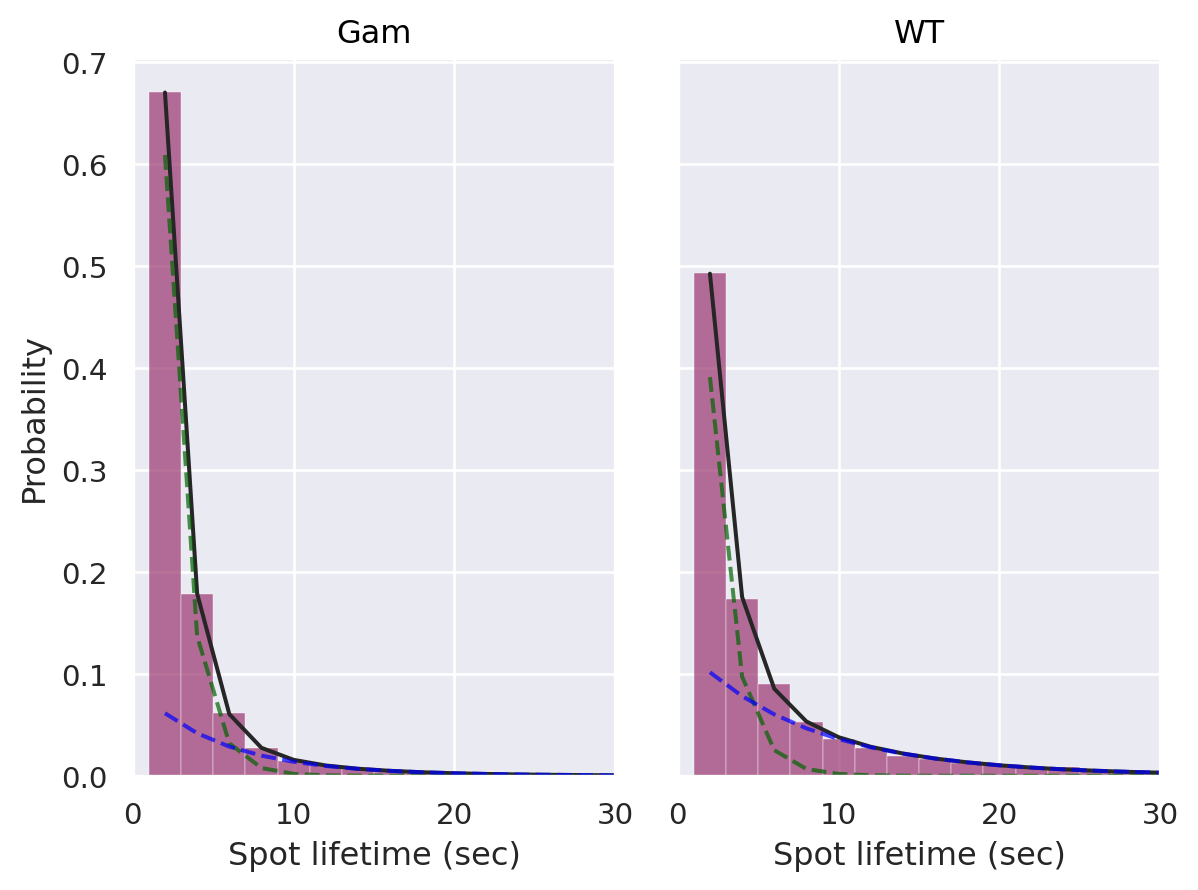

In [32]:
import seaborn.objects as so

df = (biexp_fit.data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      .query("Cipro == '30 ng/mL'")
      )


(
    so.Plot(df, x='TrackLength_s', color='Cipro')
    .facet(col='Strain', order=['Gam', 'WT'])
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='blue', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .scale(color=so.Nominal('flare',  order=['0', '30 ng/mL']))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Gam_cipro30_fits.svg', format='svg', bbox_inches='tight')
)

#### Determine a threshold above which spots are 99% long-lived

In [11]:
lifetime_thresholds = (biexp_fit.data
                       .query('Strain == "Gam"')  # Thresholding is only based on Gam data
                       .loc[biexp_fit.data.p_slow > 0.8]
                       .groupby('Dataset')
                       .agg({'TrackLength':'min'})
                       .reset_index()
                       .rename(columns={'TrackLength':'lifetime_threshold'})
                       )

display(lifetime_thresholds)

print(f'Median lifetime threshold: {lifetime_thresholds.lifetime_threshold.median()}')

,Dataset,lifetime_threshold
0,240227_2,5.0
1,240227_4,5.0
2,240301_1,6.0
3,240301_2,4.0


Median lifetime threshold: 5.0


#### Fit parameters

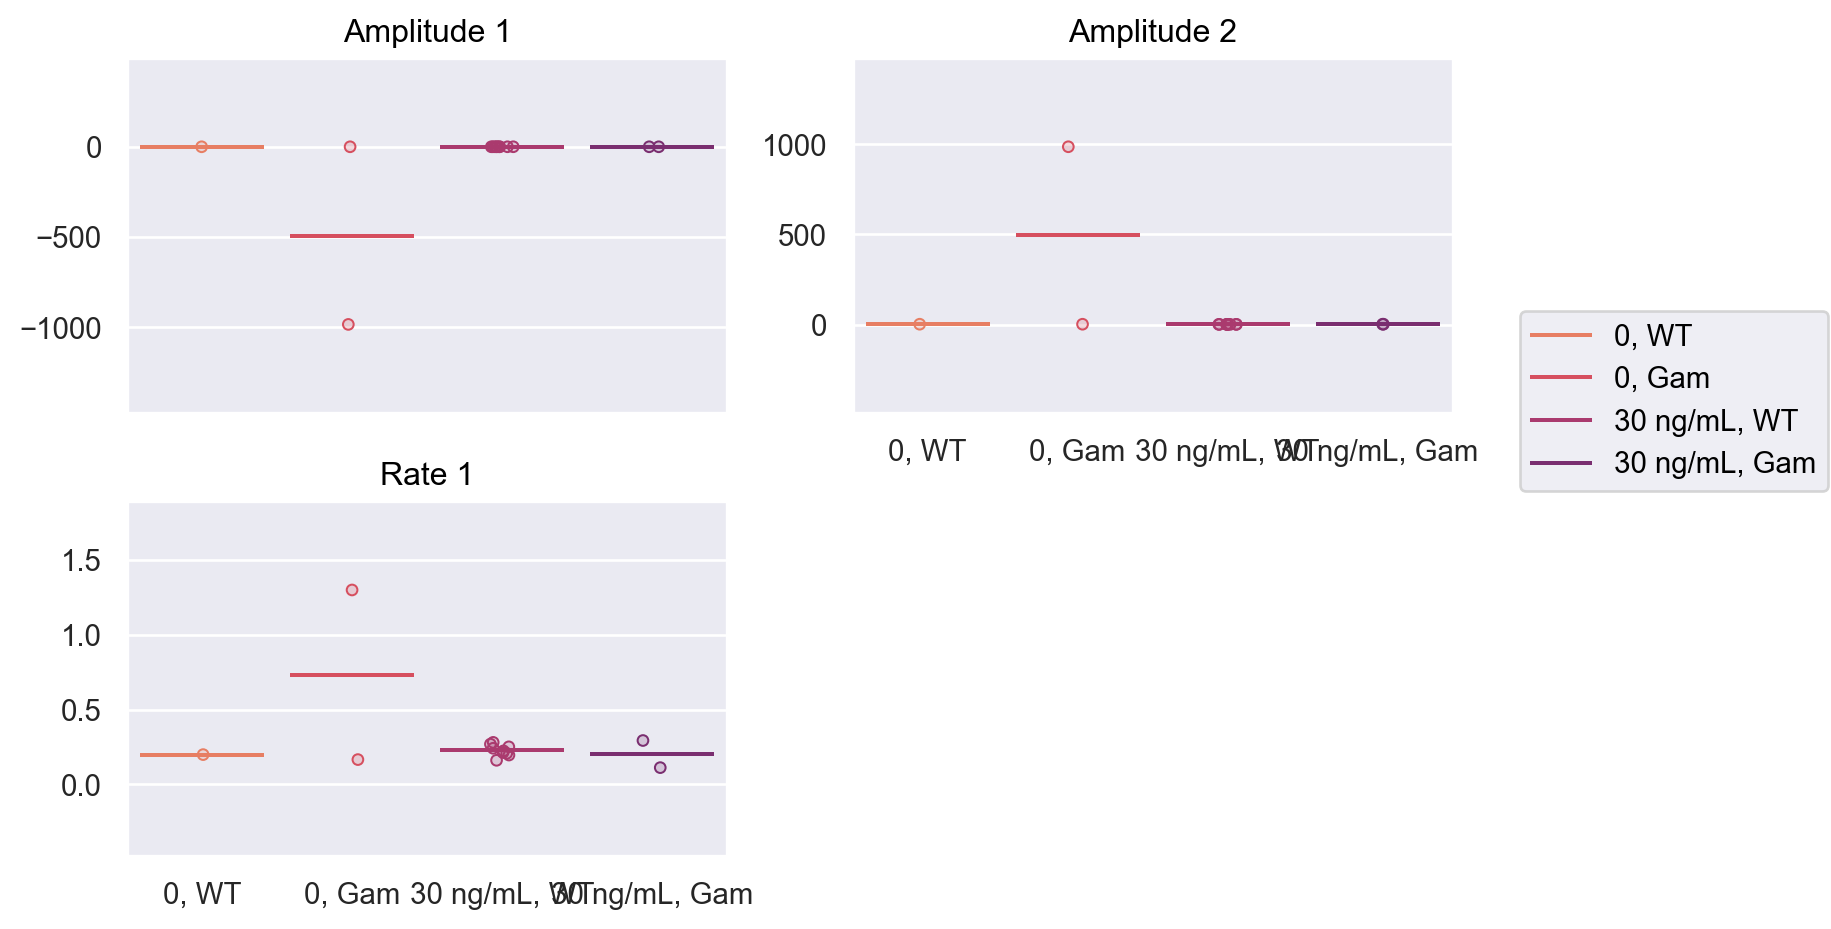

In [20]:
import seaborn.objects as so

biexp_parameters = biexp_fit.get_fit_parameters(param_names=['Amplitude 1', 'Rate 1', 'Amplitude 2', 'Rate 2'])

(
    so.Plot(biexp_parameters, x='Group', y='Fitted_param', color='Group')
    .layout(size=(8, 5))
    .facet(col='Param_name', wrap=2)
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color=so.Nominal('flare',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam']), x=so.Nominal('flare',  order=['0, WT', '0, Gam', '30 ng/mL, WT', '30 ng/mL, Gam']))
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

## RecB spot positions

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

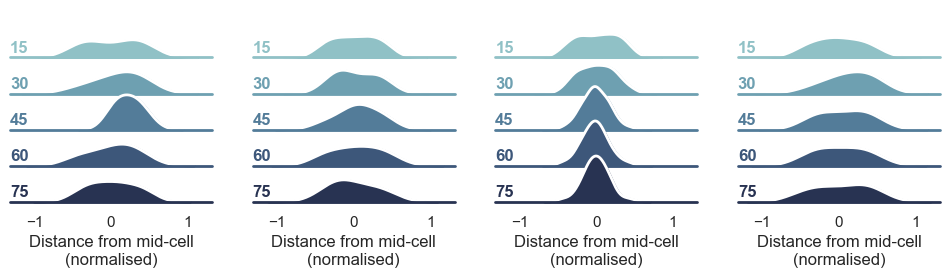

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', 
              midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5,
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=15, binlabels='left')
      .set_type(object_name='RecB_spots', type_dict={'Time_min_bin':'int'})
      .RecB_spots
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Group", aspect=6, height=.5, palette=sns.color_palette('flare'))

# Draw the densities in a few steps
g.map(sns.kdeplot, "midCellDist",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "midCellDist", clip_on=False, color="w", lw=2, bw_adjust=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(row, color, label):
      ax = plt.gca()
      ax.text(0, .2, row.iloc[0], fontweight="bold", color=color,
              ha="left", va="center", transform=ax.transAxes)
      if row.iloc[0] == 15.0:
            ax.text(.5, 1.2, label, color='k',
                  ha="center", va="center", transform=ax.transAxes)

g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)
g.fig.supylabel('Time (min)', x=.1, y=.4)
plt.show()

# plt.savefig(fname='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_position.svg', format='svg', bbox_inches='tight')